# Coursera Capstone: Foursquare Density Analysis
by Ryan Ruff

## Background
When I first connected to the Foursquare API, I did a test search around my current location (Portsmouth, VA) and had a dismal selection of venues to look at.  

As my capstone project, I thought it might be interesting to see if I could use the Foursquare API to locate other Virginia cities with low Foursquare "venue density". 

I'm curious to found out what characteristics these cities share in common.  I think this information might be valuable to providers of APIs like Foursquare, because
it would allow them to enact targeted plans to engage excluded communities and increase coverage of their app.

## Data Sources

* List of Virginia Cities from Wikipedia
* Geolocation data scraped from Geonames.org 
* Foursquare API

My tentative plan is to use the list of VA Zip codes to find an initial list of coordinates, then use the Foursquare API to sample the density of venues around that location.

## Methodology

The following code documents the process I used to complete my analysis.

In [159]:
# Start by importing the libraries I'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
#Install folium as needed 
#!pip install folium
import folium

from urllib.parse import quote

In [65]:
# Webscrape Wikipedia for a list of VA cities
wikicities = requests.get('https://en.wikipedia.org/wiki/List_of_cities_and_counties_in_Virginia')

In [66]:
# Use BeautifulSoup to clean it up
wikisoup = BeautifulSoup(wikicities.text,'html.parser')


In [96]:
tables = wikisoup.find_all("table")
rows = tables[3].find_all('tr')
def cell_cleaner(c):
    return c.get_text().strip()
headers = list(map(cell_cleaner,rows[0].find_all('th')))

df_dict = dict()
for h in headers:
    df_dict[h]=[]
for r in rows[1:]:
    tds = r.find_all('td')
    for i in range(len(headers)):
        if (i == 0):
            df_dict[headers[i]].append(r.th.get_text().strip())
        elif (i < len(tds)):
            df_dict[headers[i]].append(cell_cleaner(tds[i-1]))
        else:
            df_dict[headers[i]].append('')

df_wiki = pd.DataFrame(df_dict)
df_wiki.head()

,City,FIPS code[4],Seat[5],Est.[5],Origin,Etymology,Population[5],Area[5],Map
0,Alexandria,510,N/A,1902[10],From Alexandria County before 1870[11],"Phillip & John Alexander, brothers and area pl...","147,391",15 sq mi(39 km2),
1,Bristol,520,N/A,1902[10],From Washington County in 1890[11],"Bristol, England","17,367",12 sq mi(31 km2),
2,Buena Vista,530,N/A,1902[10],From Rockbridge County in 1892[11],"from the Buena Vista Company, which founded an...","6,349",7 sq mi(18 km2),
3,Charlottesville,540,N/A,1902[10],From Albemarle County in 1888[11],"Charlotte of Mecklenburg-Strelitz, wife of Kin...","45,049",10 sq mi(26 km2),
4,Chesapeake,550,N/A,1963,Formed out of consolidation of Norfolk County ...,Chesapeake tribe,"222,209",341 sq mi(883 km2),


In [97]:
df_wiki['City']

0           Alexandria
1              Bristol
2          Buena Vista
3      Charlottesville
4           Chesapeake
5     Colonial Heights
6            Covington
7             Danville
8              Emporia
9              Fairfax
10        Falls Church
11            Franklin
12      Fredericksburg
13               Galax
14             Hampton
15        Harrisonburg
16            Hopewell
17           Lexington
18           Lynchburg
19            Manassas
20       Manassas Park
21        Martinsville
22        Newport News
23             Norfolk
24              Norton
25          Petersburg
26            Poquoson
27          Portsmouth
28             Radford
29            Richmond
30             Roanoke
31               Salem
32            Staunton
33             Suffolk
34      Virginia Beach
35          Waynesboro
36        Williamsburg
37          Winchester
Name: City, dtype: object

In [101]:
quote(df_wiki['City'][0]+' Virginia')

'Alexandria%20Virginia'

In [102]:
# Webscrape VA zip codes from Geonames.org
def webscrape_zip_codes(city):
    query = city+" Virginia"
    geonames = requests.get('http://www.geonames.org/postalcode-search.html?q='+query+'&country=US')
    geosoup = BeautifulSoup(geonames.text,'html.parser')
    tablesoup = geosoup.find('table',attrs={'class':"restable"})
    rows = tablesoup.find_all('tr')
    num_rows = len(rows)


    headers = list(map(cell_cleaner,rows[0].find_all('th')))
    num_cols = len(headers)
    df_dict = {'Loc':[]}

    for h in headers:
        df_dict[h]=[]

    
    for r in range(int(num_rows/2)-1):
        tds = rows[2*r+1].find_all('td')
        for i in range(num_cols):
            df_dict[headers[i]].append(cell_cleaner(tds[i]))
        df_dict['Loc'].append(rows[2*r+2].find('small').get_text()) 
    df = pd.DataFrame(df_dict)
    return df


In [106]:
# scrap all the zip codes for each city
city_dfs = []
for city in df_wiki['City']:
    city_dfs.append(webscrape_zip_codes(city))

In [108]:
df_zipcodes = pd.concat(city_dfs)
df_zipcodes.shape

(1581, 8)

In [112]:
df_zipcodes.columns = ['Loc', 'Num', 'City', 'Code', 'Country', 'State', 'County', 'Admin3']
df_zipcodes = df_zipcodes[['Loc', 'City', 'Code', 'State', 'County']]
df_zipcodes.head()

,Loc,City,Code,State,County
0,38.791/-77.081,Alexandria,22303,Virginia,Fairfax
1,38.759/-77.087,Alexandria,22306,Virginia,Fairfax
2,38.779/-77.119,Alexandria,22310,Virginia,Fairfax
3,38.819/-77.148,Alexandria,22312,Virginia,Fairfax
4,38.771/-77.066,Alexandria,22307,Virginia,Fairfax


In [115]:
lats = []
longs = []
for loc in df_zipcodes["Loc"]:
    strs = str(loc).split('/')
    lats.append(float(strs[0]))
    longs.append(float(strs[1]))
df_zipcodes['Latitude'] = lats
df_zipcodes['Longitude'] = longs
df_zipcodes.head()

,Loc,City,Code,State,County,Latitude,Longitude
0,38.791/-77.081,Alexandria,22303,Virginia,Fairfax,38.791,-77.081
1,38.759/-77.087,Alexandria,22306,Virginia,Fairfax,38.759,-77.087
2,38.779/-77.119,Alexandria,22310,Virginia,Fairfax,38.779,-77.119
3,38.819/-77.148,Alexandria,22312,Virginia,Fairfax,38.819,-77.148
4,38.771/-77.066,Alexandria,22307,Virginia,Fairfax,38.771,-77.066


In [119]:
df_zipcodes = df_zipcodes[df_zipcodes['State']=='Virginia']

In [120]:
df_cities = df_zipcodes.groupby('City').mean().reset_index()

In [133]:
print(df_cities.shape)
df_cities.head()

(86, 3)


,City,Latitude,Longitude
0,Alexandria,38.788207,-77.091483
1,Annandale,38.831000,-77.214000
2,Bent Mountain,37.155000,-80.122000
3,Boones Mill,37.133000,-79.956000
4,Bristol,36.613200,-82.190600


In [136]:
mean_lat = df_cities['Latitude'].mean()
mean_lng = df_cities['Longitude'].mean()

map_VA = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)
for lat, lng, city in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_VA) 
map_VA

In [137]:
# next let's load up the Foursquare API
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
VERSION = '20200311'

In [142]:
def getNearbyVenues(name, lat, lng, radius=500, limit=100):    
         
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        limit)
        
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    return [(name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]

In [149]:
avg_venues = []
for city in df_cities["City"]:
    num_venues = []
    df_zips = df_zipcodes[df_zipcodes["City"]==city]
    for zipcode,lat,lng in zip(df_zips["Code"],df_zips["Latitude"],df_zips["Longitude"]):
        num_venues.append(len(getNearbyVenues(zipcode,lat,lng)))
    avg_venues.append(np.mean(num_venues))

df_cities["Avg Num Venues"] = avg_venues
df_cities.head()

,City,Latitude,Longitude,Avg Num Venues
0,Alexandria,38.788207,-77.091483,20.068966
1,Annandale,38.831000,-77.214000,7.000000
2,Bent Mountain,37.155000,-80.122000,0.000000
3,Boones Mill,37.133000,-79.956000,0.000000
4,Bristol,36.613200,-82.190600,13.200000


In [155]:
df_cities.sort_values(by="Avg Num Venues",inplace=True)
df_cities.head()

,City,Latitude,Longitude,Avg Num Venues
85,Wirtz,37.082,-79.757,0.0
63,Redwood,37.007,-79.914,0.0
62,Randolph,36.952,-78.705,0.0
56,Oakton,38.885,-77.323,0.0
73,Union Hall,37.013,-79.686,0.0


In [156]:
df_cities.tail()

,City,Latitude,Longitude,Avg Num Venues
54,Norfolk,36.896810,-76.258476,17.238095
0,Alexandria,38.788207,-77.091483,20.068966
37,Harrisonburg,38.457750,-78.858000,22.750000
49,Mc Lean,38.936333,-77.188000,29.333333
50,Merrifield,38.856600,-77.254600,31.600000


It looks like a substantial number of Virginia Cities returned no venues.  The city with the most was Merrifield, which had approximately 31 venues per zipcode.

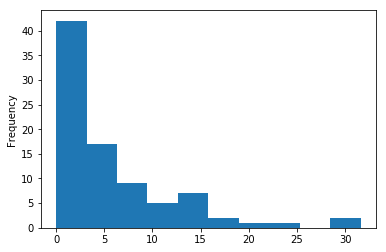

In [160]:
df_cities["Avg Num Venues"].plot(kind='hist')

In [161]:
df_cities[df_cities["City"]=="Portsmouth"]

,City,Latitude,Longitude,Avg Num Venues
60,Portsmouth,36.84025,-76.3435,8.875


In [162]:
df_cities["Avg Num Venues"].describe()

count    86.000000
mean      5.524151
std       6.583844
min       0.000000
25%       1.000000
50%       3.541667
75%       8.247024
max      31.600000
Name: Avg Num Venues, dtype: float64

In [166]:
Q1 = df_cities["Avg Num Venues"].quantile(.25)
Q2 = df_cities["Avg Num Venues"].quantile(.5)
Q3 = df_cities["Avg Num Venues"].quantile(.75)
def get_quartile(x):
    if (x < Q1):
        return 0
    elif (x < Q2):
        return 1
    elif (x < Q3):
        return 2
    else:
        return 3
df_cities["Quartile"] = df_cities["Avg Num Venues"].map(get_quartile)
df_cities.tail()

,City,Latitude,Longitude,Avg Num Venues,Quartile
54,Norfolk,36.896810,-76.258476,17.238095,3
0,Alexandria,38.788207,-77.091483,20.068966,3
37,Harrisonburg,38.457750,-78.858000,22.750000,3
49,Mc Lean,38.936333,-77.188000,29.333333,3
50,Merrifield,38.856600,-77.254600,31.600000,3


In [168]:
# Let's map again, but color coded by quartile
colors = ['red','orange','yellow','green']
map_VA = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)
for lat, lng, city,q in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City'], df_cities['Quartile']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[q],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_VA) 
map_VA

Visually, we can see that the cities with the highest Foursquare usage are near major urban centers.  A few outliers appear to be located near national parks.